## How To Use This Notebook



1.   Request experimental data from authors
2.   Store the data in a folder called AlloxExperiments in your google drive or local drive. 



In [ ]:
# Folder structure
'''
AlloxExperiments
├── alexnet-experiments
│   ├── 0.log
│   ...
│   └── 599.log
├── _lenet-experiments
│   ├── 0.log
│   ...
│   └── 599.log
├── _LeNet Baseline
│   ├── 0.log
│   ...
│   └── 9.log
├── _plots
│   ├── alexnet
│   └── lenet
'''

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/

/content/drive/MyDrive


## Calculate Baselines

In [4]:
import re 

def calc_baseline_lenet(output):
    if "<TIME_WRITTER_OUTPUT>[" not in output or "]</TIME_WRITTER_OUTPUT>" not in output:
        raise Exception("Invalid time writter output: " + output)
    s = output.split("<TIME_WRITTER_OUTPUT>[")[-1]
    s = s.split("]</TIME_WRITTER_OUTPUT>")[0]
    s = s.replace('"\n"', '')
    s = s.split(", ")
    s = list(float(i) for i in s)
    sum_total = 0
    for i in s:
        sum_total+=i
    return sum_total
    
def calc_baseline_alexnet(output):
    if "<TIME_WRITTER_OUTPUT>[" not in output or "]</TIME_WRITTER_OUTPUT>" not in output:
        raise Exception("Invalid time writter output: " + output)
    
    splits = output.split("<TIME_WRITTER_OUTPUT>[")
    del splits[0]
    parses = []
    for s in splits:
        s = s.split("]</TIME_WRITTER_OUTPUT>")[0]
        s = s.replace('"\n"', '')
        s = s.split(", ")
        s = list(float(i) for i in s)
        parses.append(s)
    m = 0
    inx = 0
    for i, parse in enumerate(parses):
        l = len(parse)
        if l > m:
            m = l
            inx = i
    times = parses[inx]
    alexnet_init.append(times[0])
    alexnet_term.append(times[-1])
    alexnet_iter_times.extend(times[1:-1])

## Parse Outputs

In [5]:
def parse_output_lenet(output):
    if "<TIME_WRITTER_OUTPUT>[" not in output or "]</TIME_WRITTER_OUTPUT>" not in output:
        raise Exception("Invalid time writter output: " + output)
    s = output.split("<TIME_WRITTER_OUTPUT>[")[-1]
    s = s.split("]</TIME_WRITTER_OUTPUT>")[0]
    s = s.replace('"\n"', '')
    s = s.split(", ")
    s = list(float(i) for i in s)
    return s

def parse_output_alexnet(output):
    if "<TIME_WRITTER_OUTPUT>[" not in output or "]</TIME_WRITTER_OUTPUT>" not in output:
        raise Exception("Invalid time writter output: " + output)
    
    splits = output.split("<TIME_WRITTER_OUTPUT>[")
    del splits[0]
    parses = []
    for s in splits:
        s = s.split("]</TIME_WRITTER_OUTPUT>")[0]
        s = s.replace('"\n"', '')
        s = s.split(", ")
        s = list(float(i) for i in s)
        parses.append(s)
    m = 0
    inx = 0
    for i, parse in enumerate(parses):
        l = len(parse)
        if l > m:
            m = l
            inx = i
    return parses[inx]

## Estimation Experiments

In [6]:
def aggregate_results(cpu_estimated, estimation_method, config, model_name):
    if model_name == "lenet":  
        if estimation_method == "linReg":
            if config == 0:
                linReg_zero_lenet.append(cpu_estimated)
            elif config == 1:
                linReg_one_lenet.append(cpu_estimated)
            elif config == 2:
                linReg_two_lenet.append(cpu_estimated)
            else:
                raise Exception("Invalid config: ", config)
        if estimation_method == "tw":
            if config == 0:
                tw_zero_lenet.append(cpu_estimated)
            elif config == 2:
                tw_two_lenet.append(cpu_estimated)
            elif config == 3:
                tw_three_lenet.append(cpu_estimated)
            else:
                raise Exception("Invalid config: ", config)
    else:
        if estimation_method == "linReg":
            if config == 0:
                linReg_zero_alexnet.append(cpu_estimated)
            elif config == 1:
                linReg_one_alexnet.append(cpu_estimated)
            elif config == 2:
                linReg_two_alexnet.append(cpu_estimated)
            else:
                raise Exception("Invalid config: ", config)
        if estimation_method == "tw":
            if config == 0:
                tw_zero_alexnet.append(cpu_estimated)
            elif config == 2:
                tw_two_alexnet.append(cpu_estimated)
            elif config == 3:
                tw_three_alexnet.append(cpu_estimated)
            else:
                raise Exception("Invalid config: ", config)

def estimate_job_time(tw_cpu_output, model_name):
    '''
    :param tw_cpu_output: single log file containing time writer output
    :param model_name: str, alexnet or lenet models
    '''
    times = []
    if model_name=="lenet":
        times = parse_output_lenet(tw_cpu_output)
    if model_name=="alexnet":
        times = parse_output_alexnet(tw_cpu_output)
    # Find arguments
    if "<ARGS>[" not in tw_cpu_output or "]</ARGS>" not in tw_cpu_output:
        raise Exception("Arguments not included: ", tw_cpu_output)
    args = tw_cpu_output.split("<ARGS>[")[-1]
    args = args.split("]</ARGS>")[0]
    args = args.replace("'", '')
    args = args.split(", ")
    
    # process args to call either linear regression or timewritter
    linearReg = False
    timeWritter = False
    config = []
    for i in args:
        if "linearRegression" in i:
            linearReg = True
        if "timeWritter" in i:
            timeWritter = True
        if "config" in i:
            config.append(i)
    if not config:
        raise Exception("No config value specified in args")
    if not linearReg and not timeWritter:
        raise Exception("Linear Regression Estimation or timewritter estimation not specified in args")
    config_num = int(config[0].split("=")[1].split("'")[0])
    
    cpu_estimated = float('inf')
    # Call linear reg estimation or time writter estimation depending on config param
    if linearReg:
        if config_num==0:
            cpu_estimated = estimate_job_time_linreg(times, 0.006, 0.009, model_name)
            aggregate_results(cpu_estimated, "linReg", config_num, model_name)
        elif config_num==1:
            cpu_estimated = estimate_job_time_linreg(times, 0.004, 0.011, model_name)
            aggregate_results(cpu_estimated, "linReg", config_num, model_name)
        elif config_num==2:
            cpu_estimated = estimate_job_time_linreg(times, 0.002, 0.013, model_name)
            aggregate_results(cpu_estimated, "linReg", config_num, model_name)
        else:
            raise Exception("Invalid config: ", config)
    if timeWritter:
        if config_num==0:
            cpu_estimated = estimate_job_time_time_writter(times, 0.002, model_name)
            aggregate_results(cpu_estimated, "tw", config_num, model_name)
        elif config_num==2:
            cpu_estimated = estimate_job_time_time_writter(times, 0.008, model_name)
            aggregate_results(cpu_estimated, "tw", config_num, model_name)
        elif config_num==3:
            cpu_estimated = estimate_job_time_time_writter(times, 0.014, model_name)
            aggregate_results(cpu_estimated, "tw", config_num, model_name)
        else:
            raise Exception("Invalid config: ", config)
    return cpu_estimated

def estimate_job_time_linreg(times, a, b, model_name):
	###################################
	#####    ESTIMATE JOB TIME    #####
	###################################
    total_iterations = 0
    if model_name == "lenet":
        total_iterations = 30000
    else:
        total_iterations = 500

	# Using a and b proportions, find corresponding epoch number
    a_epochs = round(total_iterations * a)
    times_iters = times[1:-1]
    b_epochs = len(times_iters)

    a_epochs_times = 0
    b_epochs_times = 0
    for i in times_iters[:a_epochs]:
        a_epochs_times += i
    for j in times_iters:
        b_epochs_times += j
    a_epochs_times += times[0]
    
    b_epochs_times += times[-1]
    b_epochs_times += times[0]
    
    cpu_estimated = float('inf')
    
    slope = (b_epochs_times - a_epochs_times) / (b_epochs - a_epochs)
    b = a_epochs_times - (slope * a_epochs)
    
    cpu_estimated = (slope*total_iterations)+b
    return cpu_estimated

def estimate_job_time_time_writter(times, proportion, model_name):

	###################################
	#####    ESTIMATE JOB TIME    #####
	###################################
    total_iterations = 0
    if model_name == "lenet":
        total_iterations = 30000
    else:
        total_iterations = 500
    cpu_estimated = float('inf')
    
    sum_times = 0
    for i in times[1:-1]:
        sum_times += i
    slope = sum_times/len(times[1:-1])
    b = times[0]+times[-1]
    
    cpu_estimated = (slope*total_iterations)+b
    return cpu_estimated

In [7]:
import numpy as np

# calculate Alexnet baselines
alexnet_init = []
alexnet_term = []
alexnet_iter_times = []

# LeNet Baselines
lenet_baselines = []

# LeNet Experimental Results
linReg_zero_lenet = [] # Model: lenet, linear regression estimation, config zero
linReg_one_lenet = []
linReg_two_lenet = []

tw_zero_lenet = []
tw_two_lenet = []
tw_three_lenet = []

# AlexNet Experimental Results
linReg_zero_alexnet = []
linReg_one_alexnet = []
linReg_two_alexnet = []

tw_zero_alexnet = []
tw_two_alexnet = []
tw_three_alexnet = []

In [8]:
from os import listdir
from os.path import isfile, join

lenet_path = "AlloxExperiments/lenet-experiments/"
alexnet_path = "AlloxExperiments/alexnet-experiments/"
lenet_bl_path = "AlloxExperiments/LetNet Baseline/"

files_lenet = [f for f in listdir(lenet_path) if isfile(join(lenet_path, f))]
files_alexnet = [f for f in listdir(alexnet_path) if isfile(join(alexnet_path, f))]
files_lenet_baselines = [f for f in listdir(lenet_bl_path) if isfile(join(lenet_bl_path, f))]

In [9]:
# LeNet Baselines
for file_name in files_lenet_baselines:
    with open(lenet_bl_path + file_name, "r") as f:
        lines = f.read()
        sum_baseline = calc_baseline_lenet(lines)
        lenet_baselines.append(sum_baseline)

# LeNet Experiments
for file_name in files_lenet:
    with open(lenet_path + file_name, "r") as f:
        lines = f.read()
        estimate_job_time(lines, "lenet")

# AlexNet Experiments
for file_name in files_alexnet:
    with open(alexnet_path + file_name, "r") as f:
        lines = f.read()
        estimate_job_time(lines, "alexnet")

# AlexNet Baselines
for file_name in files_alexnet:
    with open(alexnet_path + file_name, "r") as f:
        lines = f.read()
        calc_baseline_alexnet(lines)

In [10]:
assert (len(linReg_zero_lenet)==100 and len(linReg_one_lenet)==100 and len(linReg_two_lenet)==100)
assert (len(tw_zero_lenet)==100 and len(tw_two_lenet)==100 and len(tw_three_lenet)==100)
assert (len(linReg_zero_alexnet)==100 and len(linReg_one_alexnet)==100 and len(linReg_two_alexnet)==100)
assert (len(tw_zero_alexnet)==100 and len(tw_two_alexnet)==100 and len(tw_three_alexnet)==100)
assert (len(lenet_baselines)==10 and len(alexnet_term)==600 and len(alexnet_init)==600)

In [11]:
# Baselines
lenet_baseline_time = np.mean(lenet_baselines)
alexnet_baseline_time = np.mean(alexnet_init) + (np.mean(alexnet_iter_times)*500) + np.mean(alexnet_term)


## LeNet Analysis

### Difference

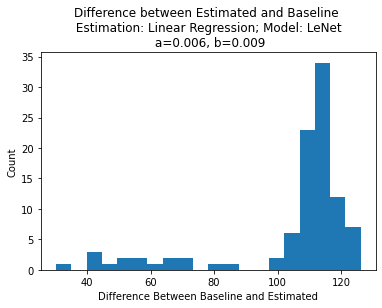

In [25]:
# LeNet Plots
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
%matplotlib inline

# Fixing random state for reproducibility
np.random.seed(19680801)

#Difference between estimated times and baseline times
linReg_zero_lenet_diff = linReg_zero_lenet - lenet_baseline_time
linReg_one_lenet_diff = linReg_one_lenet - lenet_baseline_time
linReg_two_lenet_diff = linReg_two_lenet - lenet_baseline_time

tw_zero_lenet_diff = tw_zero_lenet - lenet_baseline_time
tw_two_lenet_diff = tw_two_lenet - lenet_baseline_time
tw_three_lenet_diff = tw_three_lenet - lenet_baseline_time

def plot_difference(diffs, title, num_bins, name):
    n, bins, patches = plt.hist(diffs, num_bins)
    plt.xlabel('Difference Between Baseline and Estimated')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/lenet/differences/"+name)

plot_difference(linReg_zero_lenet_diff, "Difference between Estimated and Baseline \n Estimation: Linear Regression; Model: LeNet \n a=0.006, b=0.009", 20, "linReg0.png")

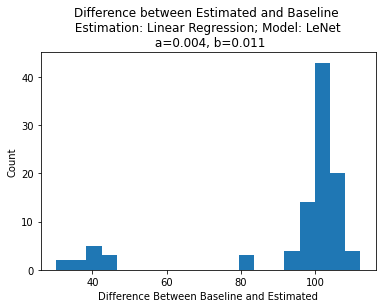

In [26]:
plot_difference(linReg_one_lenet_diff, "Difference between Estimated and Baseline \n Estimation: Linear Regression; Model: LeNet \n a=0.004, b=0.011", 20, "linReg1.png")

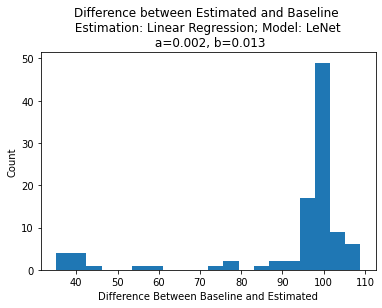

In [27]:
plot_difference(linReg_two_lenet_diff, "Difference between Estimated and Baseline \n Estimation: Linear Regression; Model: LeNet \n a=0.002, b=0.013", 20, "linReg2.png")

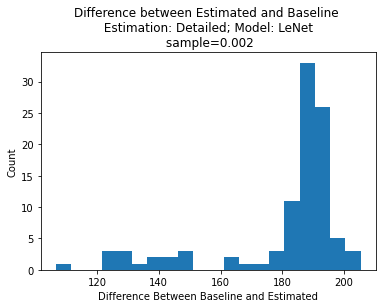

In [28]:
plot_difference(tw_zero_lenet_diff, "Difference between Estimated and Baseline \n Estimation: Detailed; Model: LeNet \n sample=0.002", 20, "tw0.png")

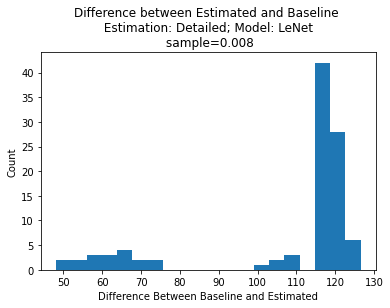

In [29]:
plot_difference(tw_two_lenet_diff, "Difference between Estimated and Baseline \n Estimation: Detailed; Model: LeNet \n sample=0.008", 20, "tw2.png")

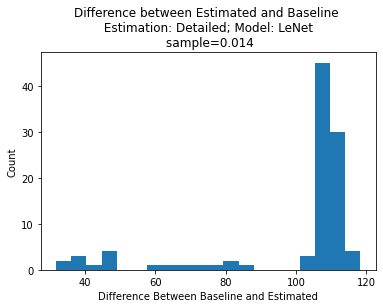

In [30]:
plot_difference(tw_three_lenet_diff, "Difference between Estimated and Baseline \n Estimation: Detailed; Model: LeNet \n sample=0.014", 20, "tw3.png")

### % Error

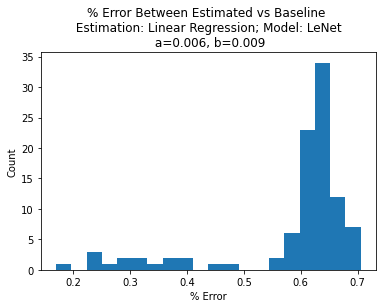

In [31]:
def plot_error(diffs, title, num_bins, name):
    n, bins, patches = plt.hist(diffs, num_bins)
    plt.xlabel('% Error')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/lenet/errors/"+name)
# % error
linReg_zero_lenet_error = np.abs(lenet_baseline_time - linReg_zero_lenet)/lenet_baseline_time
linReg_one_lenet_error = np.abs(lenet_baseline_time - linReg_one_lenet)/lenet_baseline_time
linReg_two_lenet_error = np.abs(lenet_baseline_time - linReg_two_lenet)/lenet_baseline_time

tw_zero_lenet_error = np.abs(lenet_baseline_time - tw_zero_lenet)/lenet_baseline_time
tw_two_lenet_error = np.abs(lenet_baseline_time - tw_two_lenet)/lenet_baseline_time
tw_three_lenet_error = np.abs(lenet_baseline_time - tw_three_lenet)/lenet_baseline_time

plot_error(linReg_zero_lenet_error, "% Error Between Estimated vs Baseline \n Estimation: Linear Regression; Model: LeNet \n a=0.006, b=0.009", 20, "linReg0.png")

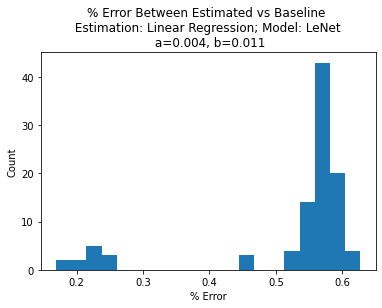

In [32]:
plot_error(linReg_one_lenet_error, "% Error Between Estimated vs Baseline \n Estimation: Linear Regression; Model: LeNet \n a=0.004, b=0.011", 20, "linReg1.png")

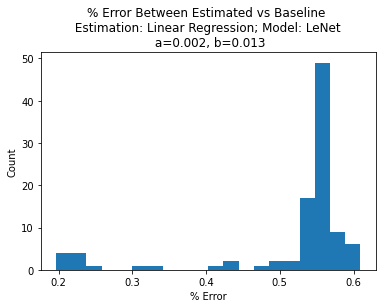

In [33]:
plot_error(linReg_two_lenet_error, "% Error Between Estimated vs Baseline \n Estimation: Linear Regression; Model: LeNet \n a=0.002, b=0.013", 20, "linReg2.png")

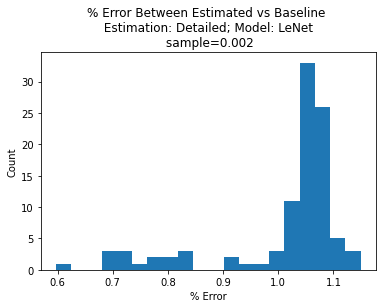

In [34]:
plot_error(tw_zero_lenet_error, "% Error Between Estimated vs Baseline \n Estimation: Detailed; Model: LeNet \n sample=0.002", 20, "tw0.png")

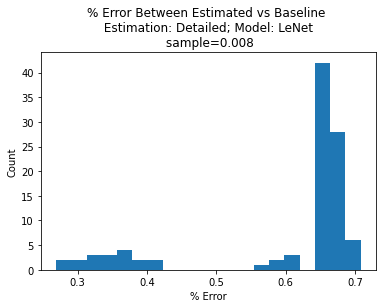

In [35]:
plot_error(tw_two_lenet_error, "% Error Between Estimated vs Baseline \n Estimation: Detailed; Model: LeNet \n sample=0.008", 20, "tw2.png")

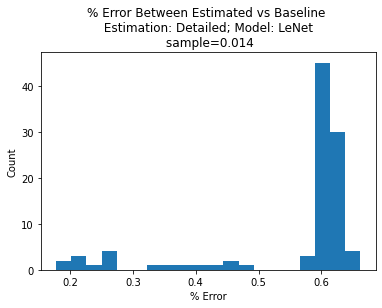

In [36]:
plot_error(tw_three_lenet_error, "% Error Between Estimated vs Baseline \n Estimation: Detailed; Model: LeNet \n sample=0.014", 20, "tw3.png")

### Times

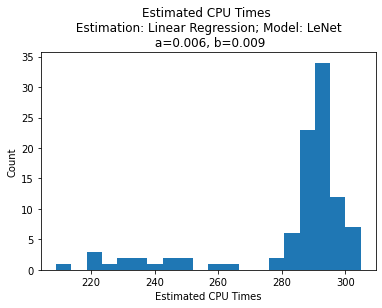

In [39]:
# Make histogram of estimated CPU times
def plot_times(times, title, num_bins, name):
    n, bins, patches = plt.hist(times, num_bins)
    plt.xlabel('Estimated CPU Times')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/lenet/times/"+name)

plot_times(linReg_zero_lenet, "Estimated CPU Times \n Estimation: Linear Regression; Model: LeNet \n a=0.006, b=0.009", 20, "linReg0.png")

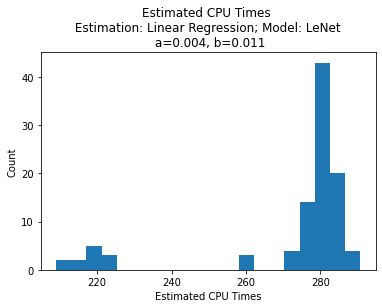

In [40]:
plot_times(linReg_one_lenet, "Estimated CPU Times \n Estimation: Linear Regression; Model: LeNet \n a=0.004, b=0.011", 20, "linReg1.png")

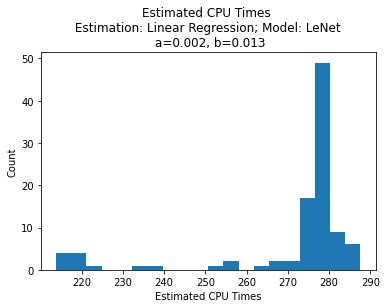

In [41]:
plot_times(linReg_two_lenet, "Estimated CPU Times \n Estimation: Linear Regression; Model: LeNet \n a=0.002, b=0.013", 20, "linReg2.png")

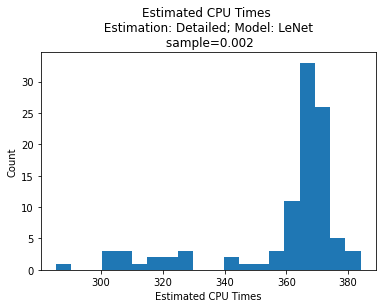

In [42]:
plot_times(tw_zero_lenet, "Estimated CPU Times \n Estimation: Detailed; Model: LeNet \n sample=0.002", 20, "tw0.png")

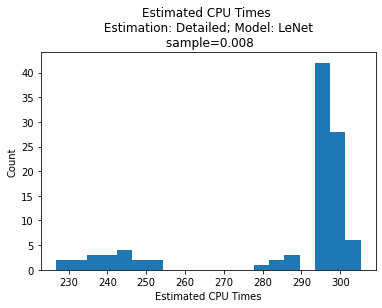

In [43]:
plot_times(tw_two_lenet, "Estimated CPU Times \n Estimation: Detailed; Model: LeNet \n sample=0.008", 20, "tw2.png")

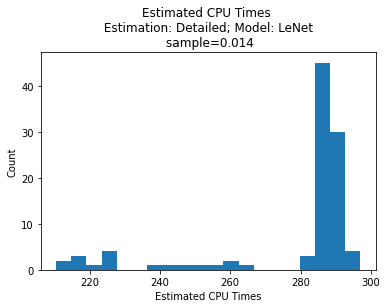

In [44]:
plot_times(tw_three_lenet, "Estimated CPU Times \n Estimation: Detailed; Model: LeNet \n sample=0.014", 20, "tw3.png")

### Errorbar

In [45]:
# Stdv, mean, mins and maxes
lenet_baseline_stdv, lenet_baseline_mean, lenet_baseline_min, lenet_baseline_max = np.std(lenet_baselines), np.mean(lenet_baselines), min(lenet_baselines), max(lenet_baselines)
linReg_zero_lenet_stdv, linReg_zero_lenet_mean, linReg_zero_lenet_min, linReg_zero_lenet_max = np.std(linReg_zero_lenet), np.mean(linReg_zero_lenet), min(linReg_zero_lenet), max(linReg_zero_lenet)
linReg_one_lenet_stdv, linReg_one_lenet_mean, linReg_one_lenet_min, linReg_one_lenet_max = np.std(linReg_one_lenet), np.mean(linReg_one_lenet), min(linReg_one_lenet), max(linReg_one_lenet)
linReg_two_lenet_stdv, linReg_two_lenet_mean, linReg_two_lenet_min, linReg_two_lenet_max = np.std(linReg_two_lenet), np.mean(linReg_two_lenet), min(linReg_two_lenet), max(linReg_two_lenet)

tw_zero_lenet_stdv, tw_zero_lenet_mean, tw_zero_lenet_min, tw_zero_lenet_max = np.std(tw_zero_lenet), np.mean(tw_zero_lenet), min(tw_zero_lenet), max(tw_zero_lenet)
tw_two_lenet_stdv, tw_two_lenet_mean, tw_two_lenet_min, tw_two_lenet_max = np.std(tw_two_lenet), np.mean(tw_two_lenet), min(tw_two_lenet), max(tw_two_lenet)
tw_three_lenet_stdv, tw_three_lenet_mean, tw_three_lenet_min, tw_three_lenet_max = np.std(tw_three_lenet), np.mean(tw_three_lenet), min(tw_three_lenet), max(tw_three_lenet)

In [46]:
print("LeNet Baseline: stdv, mean, min, max: ", lenet_baseline_stdv, ", ", lenet_baseline_mean, ", ", lenet_baseline_min, ", ", lenet_baseline_max)
print("LeNet LinReg, Config 0: stdv, mean, min, max: ", linReg_zero_lenet_stdv, ", ", linReg_zero_lenet_mean, ", ", linReg_zero_lenet_min, ", ", linReg_zero_lenet_max)
print("LeNet LinReg, Config 1: stdv, mean, min, max: ", linReg_one_lenet_stdv, ", ", linReg_one_lenet_mean, ", ", linReg_one_lenet_min, ", ", linReg_one_lenet_max)
print("LeNet LinReg, Config 2: stdv, mean, min, max: ", linReg_two_lenet_stdv, ", ", linReg_two_lenet_mean, ", ", linReg_two_lenet_min, ", ", linReg_two_lenet_max)

print("LeNet Detailed Est, Config 0: stdv, mean, min, max: ", tw_zero_lenet_stdv, ", ", tw_zero_lenet_mean, ", ", tw_zero_lenet_min, ", ", tw_zero_lenet_max)
print("LeNet Detailed Est, Config 1: stdv, mean, min, max: ", tw_two_lenet_stdv, ", ", tw_two_lenet_mean, ", ", tw_two_lenet_min, ", ", tw_two_lenet_max)
print("LeNet Detailed Est, Config 2: stdv, mean, min, max: ", tw_three_lenet_stdv, ", ", tw_three_lenet_mean, ", ", tw_three_lenet_min, ", ", tw_three_lenet_max)

LeNet Baseline: stdv, mean, min, max:  1.4014685177968365 ,  178.7087746978 ,  175.936865458 ,  180.497006134
LeNet LinReg, Config 0: stdv, mean, min, max:  21.819829836269893 ,  283.13538018259266 ,  209.0555582763511 ,  304.7321453173344
LeNet LinReg, Config 1: stdv, mean, min, max:  20.828343617845178 ,  272.7556376290509 ,  208.9483932739985 ,  290.7998478961443
LeNet LinReg, Config 2: stdv, mean, min, max:  18.425086031121456 ,  271.0005316963945 ,  213.80236995417854 ,  287.6083534620946
LeNet Detailed Est, Config 0: stdv, mean, min, max:  21.171210693217358 ,  359.264251375125 ,  285.46233065317665 ,  384.05182377492383
LeNet Detailed Est, Config 1: stdv, mean, min, max:  22.060277888029304 ,  286.39608665343354 ,  226.8209763760442 ,  305.2144967729828
LeNet Detailed Est, Config 2: stdv, mean, min, max:  22.09041279505704 ,  278.26248084453044 ,  210.45921942527048 ,  297.03231169213376


<Figure size 3600x4320 with 0 Axes>

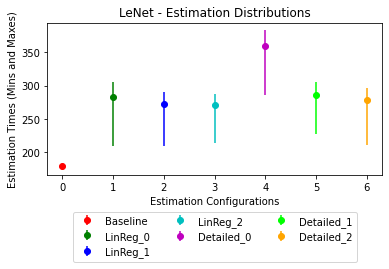

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(50,60))

y = np.asarray([lenet_baseline_mean, linReg_zero_lenet_mean, linReg_one_lenet_mean, linReg_two_lenet_mean, tw_zero_lenet_mean, tw_two_lenet_mean, tw_three_lenet_mean])
# yerr = [cm_sim_std, cw_sim_std, ca_sim_std, random_sim_std, cmc_sim_std, cwc_sim_std, cr_sim_std, stopsign_sim_std]

yerr_vals = np.asarray([[lenet_baseline_min, lenet_baseline_max], [linReg_zero_lenet_min, linReg_zero_lenet_max], [linReg_one_lenet_min, linReg_one_lenet_max], 
        [linReg_two_lenet_min, linReg_two_lenet_max], [tw_zero_lenet_min, tw_zero_lenet_max], [tw_two_lenet_min, tw_two_lenet_max], [tw_three_lenet_min, tw_three_lenet_max]]).T
yerr = np.abs(yerr_vals-y)

fig = plt.figure()
colors = ['r', 'g', 'b', 'c', 'm', 'lime', 'orange']
for i in range(7):
    plt.errorbar(np.asarray([i]), np.asarray([y[i]]), yerr=yerr[:, i:i+1], fmt='o', color=colors[i], ecolor=colors[i])

plt.legend(['Baseline', 'LinReg_0', 'LinReg_1', 'LinReg_2', 'Detailed_0', 'Detailed_1', 'Detailed_2'], loc="lower center", bbox_to_anchor=(0.5, -0.6), ncol=3)
fig.subplots_adjust(bottom=0.35)

plt.title("LeNet - Estimation Distributions")
plt.xlabel("Estimation Configurations")
plt.ylabel("Estimation Times (Mins and Maxes)")
plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/lenet/errorbar_mins_maxes/"+"lenet_summary.png")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  app.launch_new_instance()


<Figure size 3600x4320 with 0 Axes>

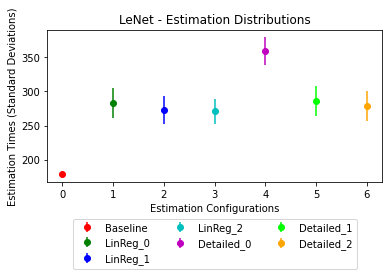

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(50,60))

y = np.asarray([lenet_baseline_mean, linReg_zero_lenet_mean, linReg_one_lenet_mean, linReg_two_lenet_mean, tw_zero_lenet_mean, tw_two_lenet_mean, tw_three_lenet_mean])
# yerr = [cm_sim_std, cw_sim_std, ca_sim_std, random_sim_std, cmc_sim_std, cwc_sim_std, cr_sim_std, stopsign_sim_std]

yerr_vals = np.asarray([[lenet_baseline_stdv], [linReg_zero_lenet_stdv], [linReg_one_lenet_stdv], 
        [linReg_two_lenet_stdv], [tw_zero_lenet_stdv], [tw_two_lenet_stdv], [tw_three_lenet_stdv]]).T
# yerr = np.abs(yerr_vals-y)

fig = plt.figure()
colors = ['r', 'g', 'b', 'c', 'm', 'lime', 'orange']
for i in range(7):
    plt.errorbar(np.asarray([i]), np.asarray([y[i]]), yerr=yerr_vals[:, i:i+1], fmt='o', color=colors[i], ecolor=colors[i])

plt.legend(['Baseline', 'LinReg_0', 'LinReg_1', 'LinReg_2', 'Detailed_0', 'Detailed_1', 'Detailed_2'], loc="lower center", bbox_to_anchor=(0.5, -0.6), ncol=3)
fig.subplots_adjust(bottom=0.35)

plt.title("LeNet - Estimation Distributions")
plt.xlabel("Estimation Configurations")
plt.ylabel("Estimation Times (Standard Deviations)")
plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/lenet/errorbar_stdv/"+"lenet_summary_stdv.png")

In [90]:

print("Linear Regression_0, lenet, avg error: ", np.mean(linReg_zero_lenet_error))
print("Linear Regression_1, lenet, avg error: ", np.mean(linReg_one_lenet_error))
print("Linear Regression_2, lenet, avg error: ", np.mean(linReg_two_lenet_error))

print("detailed_0, lenet, avg error: ", np.mean(tw_zero_lenet_error))
print("detailed_2, lenet, avg error: ", np.mean(tw_two_lenet_error))
print("detailed_3, lenet, avg error: ", np.mean(tw_three_lenet_error))

Linear Regression_0, lenet, avg error:  0.584339552780103
Linear Regression_1, lenet, avg error:  0.5262576674832337
Linear Regression_2, lenet, avg error:  0.5164366279980463
detailed_0, lenet, avg error:  1.0103335831306988
detailed_2, lenet, avg error:  0.6025854753787826
detailed_3, lenet, avg error:  0.5570722887842393


## AlexNet Analysis

### Difference

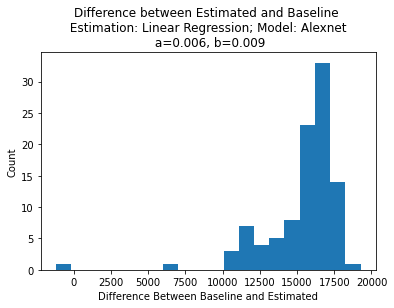

In [72]:
# AlexNet Plots
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Fixing random state for reproducibility
np.random.seed(19680801)

#Difference between estimated times and baseline times
linReg_zero_alexnet_diff = linReg_zero_alexnet - alexnet_baseline_time
linReg_one_alexnet_diff = linReg_one_alexnet - alexnet_baseline_time
linReg_two_alexnet_diff = linReg_two_alexnet - alexnet_baseline_time

tw_zero_alexnet_diff = tw_zero_alexnet - alexnet_baseline_time
tw_two_alexnet_diff = tw_two_alexnet - alexnet_baseline_time
tw_three_alexnet_diff = tw_three_alexnet - alexnet_baseline_time

def plot_difference(diffs, title, num_bins, name):
    n, bins, patches = plt.hist(diffs, num_bins)
    plt.xlabel('Difference Between Baseline and Estimated')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/alexnet/differences/"+name+".png")

plot_difference(linReg_zero_alexnet_diff, "Difference between Estimated and Baseline \n Estimation: Linear Regression; Model: Alexnet \n a=0.006, b=0.009", 20, "linReg0")

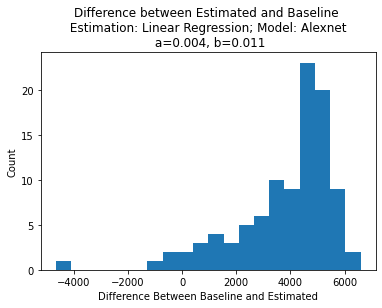

In [73]:
plot_difference(linReg_one_alexnet_diff, "Difference between Estimated and Baseline \n Estimation: Linear Regression; Model: Alexnet \n a=0.004, b=0.011", 20, "linReg1")

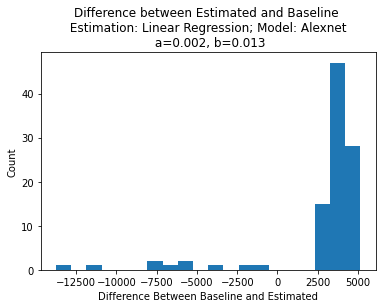

In [74]:
plot_difference(linReg_two_alexnet_diff, "Difference between Estimated and Baseline \n Estimation: Linear Regression; Model: Alexnet \n a=0.002, b=0.013", 20, "linReg2")

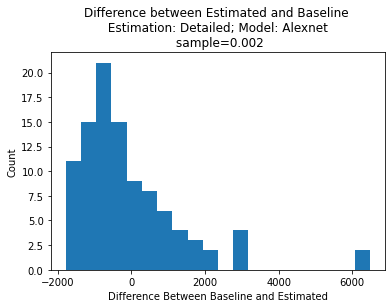

In [75]:
plot_difference(tw_zero_alexnet_diff, "Difference between Estimated and Baseline \n Estimation: Detailed; Model: Alexnet \n sample=0.002", 20, "tw0")

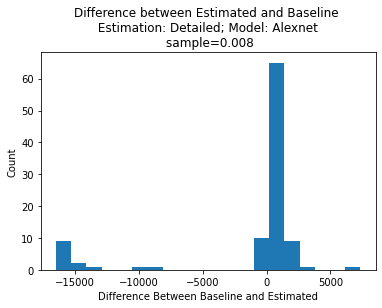

In [76]:
plot_difference(tw_two_alexnet_diff, "Difference between Estimated and Baseline \n Estimation: Detailed; Model: Alexnet \n sample=0.008", 20, "tw2")

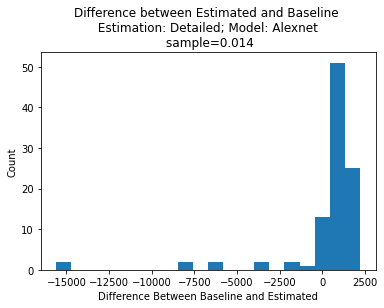

In [77]:
plot_difference(tw_three_alexnet_diff, "Difference between Estimated and Baseline \n Estimation: Detailed; Model: Alexnet \n sample=0.014", 20, "tw3")

### % Error

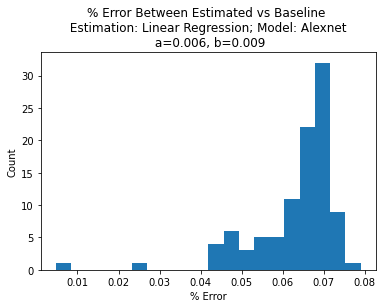

In [78]:
def plot_error(diffs, title, num_bins, name):
    n, bins, patches = plt.hist(diffs, num_bins)
    plt.xlabel('% Error')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/alexnet/errors/"+name+".png")
# % error
linReg_zero_alexnet_error = np.abs(alexnet_baseline_time - linReg_zero_alexnet)/alexnet_baseline_time
linReg_one_alexnet_error = np.abs(alexnet_baseline_time - linReg_one_alexnet)/alexnet_baseline_time
linReg_two_alexnet_error = np.abs(alexnet_baseline_time - linReg_two_alexnet)/alexnet_baseline_time

tw_zero_alexnet_error = np.abs(alexnet_baseline_time - tw_zero_alexnet)/alexnet_baseline_time
tw_two_alexnet_error = np.abs(alexnet_baseline_time - tw_two_alexnet)/alexnet_baseline_time
tw_three_alexnet_error = np.abs(alexnet_baseline_time - tw_three_alexnet)/alexnet_baseline_time

plot_error(linReg_zero_alexnet_error, "% Error Between Estimated vs Baseline \n Estimation: Linear Regression; Model: Alexnet \n a=0.006, b=0.009", 20, "linReg0")

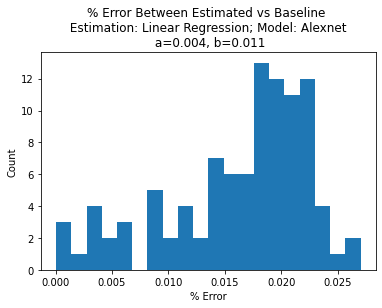

In [79]:
plot_error(linReg_one_alexnet_error, "% Error Between Estimated vs Baseline \n Estimation: Linear Regression; Model: Alexnet \n a=0.004, b=0.011", 20, "linReg1")

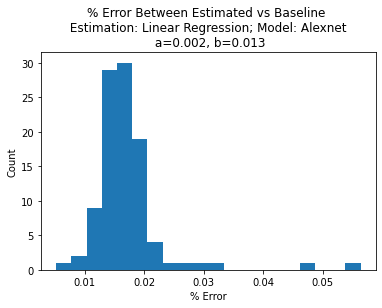

In [80]:
plot_error(linReg_two_alexnet_error, "% Error Between Estimated vs Baseline \n Estimation: Linear Regression; Model: Alexnet \n a=0.002, b=0.013", 20, "linReg2")

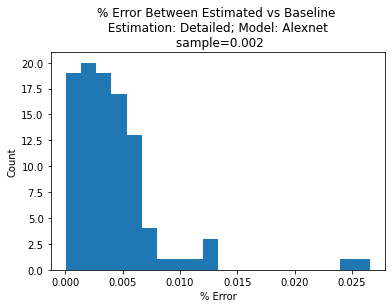

In [81]:
plot_error(tw_zero_alexnet_error, "% Error Between Estimated vs Baseline \n Estimation: Detailed; Model: Alexnet \n sample=0.002", 20, "tw0")

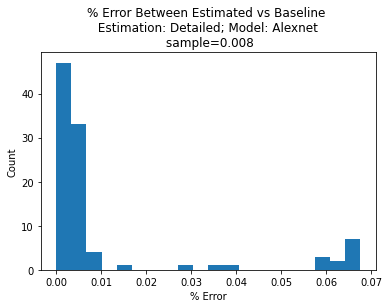

In [82]:
plot_error(tw_two_alexnet_error, "% Error Between Estimated vs Baseline \n Estimation: Detailed; Model: Alexnet \n sample=0.008", 20, "tw2")

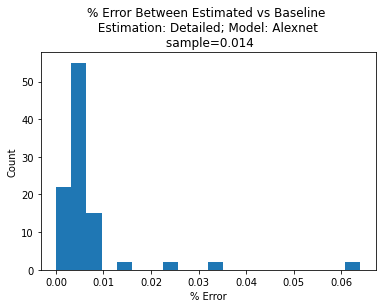

In [83]:
plot_error(tw_three_alexnet_error, "% Error Between Estimated vs Baseline \n Estimation: Detailed; Model: Alexnet \n sample=0.014", 20, "tw3")

### Times

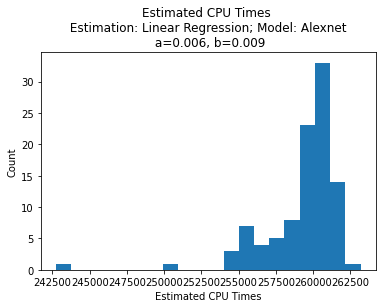

In [84]:
# Make histogram of estimated CPU times
def plot_times(times, title, num_bins, name):
    n, bins, patches = plt.hist(times, num_bins)
    plt.xlabel('Estimated CPU Times')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/alexnet/times/"+name+".png")

plot_times(linReg_zero_alexnet, "Estimated CPU Times \n Estimation: Linear Regression; Model: Alexnet \n a=0.006, b=0.009", 20, "linReg0")

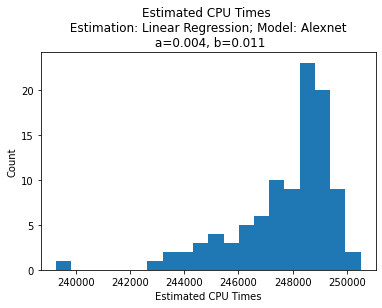

In [85]:
plot_times(linReg_one_alexnet, "Estimated CPU Times \n Estimation: Linear Regression; Model: Alexnet \n a=0.004, b=0.011", 20, "linReg1")

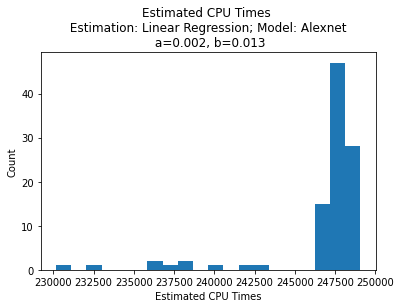

In [86]:
plot_times(linReg_two_alexnet, "Estimated CPU Times \n Estimation: Linear Regression; Model: Alexnet \n a=0.002, b=0.013", 20, "linReg2")

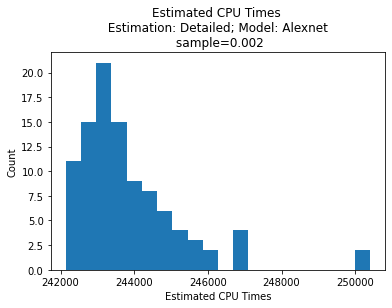

In [87]:
plot_times(tw_zero_alexnet, "Estimated CPU Times \n Estimation: Detailed; Model: Alexnet \n sample=0.002", 20, "tw0")

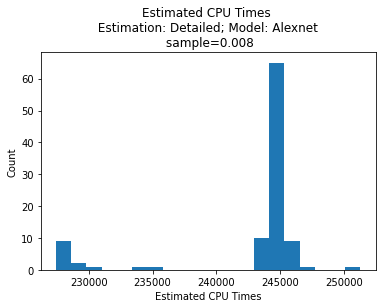

In [88]:
plot_times(tw_two_alexnet, "Estimated CPU Times \n Estimation: Detailed; Model: Alexnet \n sample=0.008", 20, "tw2")

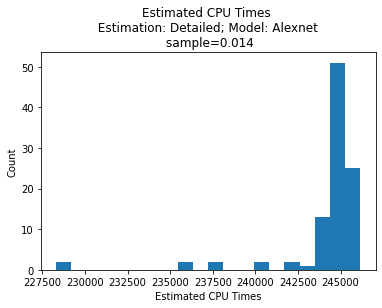

In [89]:
plot_times(tw_three_alexnet, "Estimated CPU Times \n Estimation: Detailed; Model: Alexnet \n sample=0.014", 20, "tw3")

### Errorbars

In [68]:
# Stdv, mean, mins and maxes
alexnet_baseline_stdv, alexnet_baseline_mean, alexnet_baseline_min, alexnet_baseline_max = 0, alexnet_baseline_time, alexnet_baseline_time, alexnet_baseline_time
linReg_zero_alexnet_stdv, linReg_zero_alexnet_mean, linReg_zero_alexnet_min, linReg_zero_alexnet_max = np.std(linReg_zero_alexnet), np.mean(linReg_zero_alexnet), min(linReg_zero_alexnet), max(linReg_zero_alexnet)
linReg_one_alexnet_stdv, linReg_one_alexnet_mean, linReg_one_alexnet_min, linReg_one_alexnet_max = np.std(linReg_one_alexnet), np.mean(linReg_one_alexnet), min(linReg_one_alexnet), max(linReg_one_alexnet)
linReg_two_alexnet_stdv, linReg_two_alexnet_mean, linReg_two_alexnet_min, linReg_two_alexnet_max = np.std(linReg_two_alexnet), np.mean(linReg_two_alexnet), min(linReg_two_alexnet), max(linReg_two_alexnet)

tw_zero_alexnet_stdv, tw_zero_alexnet_mean, tw_zero_alexnet_min, tw_zero_alexnet_max = np.std(tw_zero_alexnet), np.mean(tw_zero_alexnet), min(tw_zero_alexnet), max(tw_zero_alexnet)
tw_two_alexnet_stdv, tw_two_alexnet_mean, tw_two_alexnet_min, tw_two_alexnet_max = np.std(tw_two_alexnet), np.mean(tw_two_alexnet), min(tw_two_alexnet), max(tw_two_alexnet)
tw_three_alexnet_stdv, tw_three_alexnet_mean, tw_three_alexnet_min, tw_three_alexnet_max = np.std(tw_three_alexnet), np.mean(tw_three_alexnet), min(tw_three_alexnet), max(tw_three_alexnet)

In [69]:
print("Alexnet Baseline: stdv, mean, min, max: ", alexnet_baseline_stdv, ", ", alexnet_baseline_mean, ", ", alexnet_baseline_min, ", ", alexnet_baseline_max)
print("Alexnet LinReg, Config 0: stdv, mean, min, max: ", linReg_zero_alexnet_stdv, ", ", linReg_zero_alexnet_mean, ", ", linReg_zero_alexnet_min, ", ", linReg_zero_alexnet_max)
print("Alexnet LinReg, Config 1: stdv, mean, min, max: ", linReg_one_alexnet_stdv, ", ", linReg_one_alexnet_mean, ", ", linReg_one_alexnet_min, ", ", linReg_one_alexnet_max)
print("Alexnet LinReg, Config 2: stdv, mean, min, max: ", linReg_two_alexnet_stdv, ", ", linReg_two_alexnet_mean, ", ", linReg_two_alexnet_min, ", ", linReg_two_alexnet_max)

print("Alexnet Detailed Est, Config 0: stdv, mean, min, max: ", tw_zero_alexnet_stdv, ", ", tw_zero_alexnet_mean, ", ", tw_zero_alexnet_min, ", ", tw_zero_alexnet_max)
print("Alexnet Detailed Est, Config 1: stdv, mean, min, max: ", tw_two_alexnet_stdv, ", ", tw_two_alexnet_mean, ", ", tw_two_alexnet_min, ", ", tw_two_alexnet_max)
print("Alexnet Detailed Est, Config 2: stdv, mean, min, max: ", tw_three_alexnet_stdv, ", ", tw_three_alexnet_mean, ", ", tw_three_alexnet_min, ", ", tw_three_alexnet_max)

Alexnet Baseline: stdv, mean, min, max:  0 ,  243920.75280790022 ,  243920.75280790022 ,  243920.75280790022
Alexnet LinReg, Config 0: stdv, mean, min, max:  2695.5991545091442 ,  259276.2390026451 ,  242749.22811409502 ,  263188.09890801966
Alexnet LinReg, Config 1: stdv, mean, min, max:  1849.52889467296 ,  247726.70907761436 ,  239269.10472280293 ,  250509.96391857383
Alexnet LinReg, Config 2: stdv, mean, min, max:  3390.299139660542 ,  246790.80249893822 ,  230167.10728634297 ,  249070.82046999162
Alexnet Detailed Est, Config 0: stdv, mean, min, max:  1433.1968945996646 ,  243875.21127954402 ,  242140.7618123548 ,  250405.8681351766
Alexnet Detailed Est, Config 1: stdv, mean, min, max:  5528.079419225931 ,  242602.87821778574 ,  227442.04055803723 ,  251273.43241403688
Alexnet Detailed Est, Config 2: stdv, mean, min, max:  2899.3823651671128 ,  244173.4519112314 ,  228307.65928681308 ,  246162.56980038778


<Figure size 3600x4320 with 0 Axes>

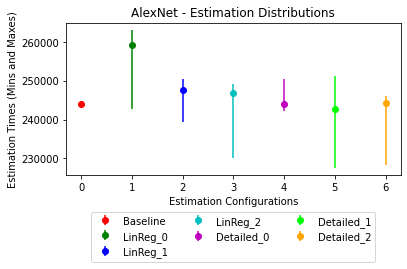

In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(50,60))

y = np.asarray([alexnet_baseline_mean, linReg_zero_alexnet_mean, linReg_one_alexnet_mean, linReg_two_alexnet_mean, tw_zero_alexnet_mean, tw_two_alexnet_mean, tw_three_alexnet_mean])

yerr_vals = np.asarray([[alexnet_baseline_min, alexnet_baseline_max], [linReg_zero_alexnet_min, linReg_zero_alexnet_max], [linReg_one_alexnet_min, linReg_one_alexnet_max], 
        [linReg_two_alexnet_min, linReg_two_alexnet_max], [tw_zero_alexnet_min, tw_zero_alexnet_max], [tw_two_alexnet_min, tw_two_alexnet_max], [tw_three_alexnet_min, tw_three_alexnet_max]]).T
yerr = np.abs(yerr_vals-y)

fig = plt.figure()
colors = ['r', 'g', 'b', 'c', 'm', 'lime', 'orange']
for i in range(7):
    plt.errorbar(np.asarray([i]), np.asarray([y[i]]), yerr=yerr[:, i:i+1], fmt='o', color=colors[i], ecolor=colors[i])

plt.legend(['Baseline', 'LinReg_0', 'LinReg_1', 'LinReg_2', 'Detailed_0', 'Detailed_1', 'Detailed_2'], loc="lower center", bbox_to_anchor=(0.5, -0.6), ncol=3)
fig.subplots_adjust(bottom=0.35)

plt.title("AlexNet - Estimation Distributions")
plt.xlabel("Estimation Configurations")
plt.ylabel("Estimation Times (Mins and Maxes)")
plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/alexnet/errorbar_mins_maxes/"+"alexnet_summary.png")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  app.launch_new_instance()


<Figure size 3600x4320 with 0 Axes>

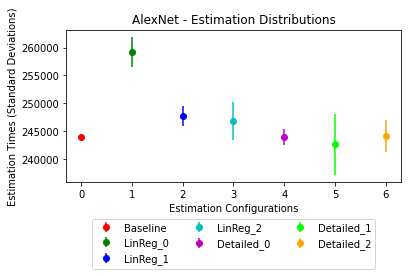

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(50,60))

y = np.asarray([alexnet_baseline_mean, linReg_zero_alexnet_mean, linReg_one_alexnet_mean, linReg_two_alexnet_mean, tw_zero_alexnet_mean, tw_two_alexnet_mean, tw_three_alexnet_mean])
# yerr = [cm_sim_std, cw_sim_std, ca_sim_std, random_sim_std, cmc_sim_std, cwc_sim_std, cr_sim_std, stopsign_sim_std]

yerr_vals = np.asarray([[alexnet_baseline_stdv], [linReg_zero_alexnet_stdv], [linReg_one_alexnet_stdv], 
        [linReg_two_alexnet_stdv], [tw_zero_alexnet_stdv], [tw_two_alexnet_stdv], [tw_three_alexnet_stdv]]).T
# yerr = np.abs(yerr_vals-y)

fig = plt.figure()
colors = ['r', 'g', 'b', 'c', 'm', 'lime', 'orange']
for i in range(7):
    plt.errorbar(np.asarray([i]), np.asarray([y[i]]), yerr=yerr_vals[:, i:i+1], fmt='o', color=colors[i], ecolor=colors[i])

plt.legend(['Baseline', 'LinReg_0', 'LinReg_1', 'LinReg_2', 'Detailed_0', 'Detailed_1', 'Detailed_2'], loc="lower center", bbox_to_anchor=(0.5, -0.6), ncol=3)
fig.subplots_adjust(bottom=0.35)

plt.title("AlexNet - Estimation Distributions")
plt.xlabel("Estimation Configurations")
plt.ylabel("Estimation Times (Standard Deviations)")
plt.savefig("/content/drive/MyDrive/AlloxExperiments/plots/alexnet/errorbar_stdv/"+"alexnet_summary_stdv.png")

In [91]:

print("Linear Regression_0, alexnet, avg error: ", np.mean(linReg_zero_alexnet_error))
print("Linear Regression_1, alexnet, avg error: ", np.mean(linReg_one_alexnet_error))
print("Linear Regression_2, alexnet, avg error: ", np.mean(linReg_two_alexnet_error))

print("detailed_0, alexnet, avg error: ", np.mean(tw_zero_alexnet_error))
print("detailed_2, alexnet, avg error: ", np.mean(tw_two_alexnet_error))
print("detailed_3, alexnet, avg error: ", np.mean(tw_three_alexnet_error))

Linear Regression_0, alexnet, avg error:  0.06304882430701858
Linear Regression_1, alexnet, avg error:  0.01613835495913344
Linear Regression_2, alexnet, avg error:  0.01710606695510849
detailed_0, alexnet, avg error:  0.004218753180073006
detailed_2, alexnet, avg error:  0.01155548292656368
detailed_3, alexnet, avg error:  0.006848505331733908
